# 1- Libraries and data loading


In [1]:
!pip install wfdb vmdpy


import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import os
import shutil
import random
from scipy.stats import kurtosis, entropy
from scipy.stats import pearsonr

try:
    from vmdpy import VMD       # The VMD algorithm
    import pywt                 # PyWavelets for DWT
except ImportError:
    print("❌ MISSING LIBRARIES: Run 'pip install vmdpy PyWavelets'")

# ==========================================
# 1. SETUP & DATA LOADING
# ==========================================

from google.colab import drive

drive.mount('/content/drive')
download_dir = '/content/drive/MyDrive/ECE DataBase'


# When the data isn't found in my google drive
if not os.path.exists(download_dir):
    raise FileNotFoundError(
        f"❌ The directory '{download_dir}' was not found in your Drive. "
        "Please ensure you uploaded the 'mitdb_data' folder to your Google Drive."
    )
else:
    print(f"✅ Google Drive directory found: '{download_dir}'")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
Mounted at /content/drive
✅ Google Drive directory found: '/content/drive/MyDrive/ECE DataBase'


# 2- Optimizers Function

In [2]:
# ==========================================
class PSO_Optimizer:
    def __init__(self, noisy_signal, n_particles=20, iterations=20):
        self.signal = noisy_signal
        self.n_particles = n_particles
        self.iterations = iterations
        self.wavelet_list = ['db4', 'db6', 'db8', 'sym4', 'sym5', 'sym8', 'coif3', 'coif5']

        # Dynamic Boundaries
        self.max_thresh = np.max(np.abs(noisy_signal)) * 0.5
        self.min_thresh = 0.01

        self.positions = []
        self.velocities = []
        self.pbest_pos = []
        self.pbest_val = []
        self.gbest_pos = None
        self.gbest_val = -np.inf

        for _ in range(n_particles):
            w_idx = random.uniform(0, len(self.wavelet_list) - 0.01)
            thresh = random.uniform(self.min_thresh, self.max_thresh)
            pos = np.array([w_idx, thresh])
            self.positions.append(pos); self.velocities.append(np.zeros(2)); self.pbest_pos.append(pos); self.pbest_val.append(-np.inf)

    def optimize(self):
        print(f"   🚀 PSO Start: Optimization in progress...")

        for t in range(self.iterations):
            # Inertia Decay
            w = 0.9 - ((t / self.iterations) * 0.5)

            for i in range(self.n_particles):
                # 1. Decode Particle
                w_idx = int(np.clip(self.positions[i][0], 0, len(self.wavelet_list)-1))
                w_name = self.wavelet_list[w_idx]
                thresh = self.positions[i][1]

                # 2. RUN THE TRIAL (Using the external function)
                # Note: We now use 'dwt_smart' instead of writing code here
                rec = dwt_smart(self.signal, w_name, thresh)

                # 3. JUDGE THE RESULT (Using the external function)
                current_score = calculate_fitness(rec)

                # 4. Update Memory
                if current_score > self.pbest_val[i]:
                    self.pbest_val[i] = current_score
                    self.pbest_pos[i] = self.positions[i].copy()
                if current_score > self.gbest_val:
                    self.gbest_val = current_score
                    self.gbest_pos = self.positions[i].copy()

            # 5. Move Particles
            for i in range(self.n_particles):
                r1, r2 = random.random(), random.random()
                self.velocities[i] = (w * self.velocities[i] +
                                      1.5 * r1 * (self.pbest_pos[i] - self.positions[i]) +
                                      1.5 * r2 * (self.gbest_pos - self.positions[i]))
                self.positions[i] += self.velocities[i]
                self.positions[i][0] = np.clip(self.positions[i][0], 0, len(self.wavelet_list)-0.01)
                self.positions[i][1] = np.clip(self.positions[i][1], self.min_thresh, self.max_thresh)

        best_w = self.wavelet_list[int(self.gbest_pos[0])]
        best_t = self.gbest_pos[1]
        print(f"      ✅ PSO Complete. Best: {best_w} | Thresh: {best_t:.4f}")
        return best_w, best_t



class SSA_Optimizer_Aligned:
    def __init__(self, noisy_signal, pop_size=12, iterations=12):
        self.signal = noisy_signal
        self.pop_size = pop_size
        self.iterations = iterations
        self.lb = [3, 500]    # K, Alpha Lower Bound
        self.ub = [10, 3000]  # K, Alpha Upper Bound

        self.positions = np.zeros((pop_size, 2))
        for i in range(pop_size):
            self.positions[i] = [random.randint(self.lb[0], self.ub[0]), random.randint(self.lb[1], self.ub[1])]
        self.best_pos = None; self.best_score = -np.inf

    def optimize(self):
        print(f"   🐟 SSA Started (Pop={self.pop_size}, Iter={self.iterations})...")
        for t in range(self.iterations):
            scores = []
            for i in range(self.pop_size):
                K, alpha = self.positions[i]

                # CRITICAL UPDATE: Calls your 'vmd_smart_process' function
                rec = vmd_smart_process(self.signal, alpha, K)

                fit = calculate_fitness(rec)
                scores.append(fit)
                if fit > self.best_score:
                    self.best_score = fit; self.best_pos = self.positions[i].copy()

            # SSA Movement Logic
            sorted_idx = np.argsort(scores)[::-1]
            self.positions = self.positions[sorted_idx]
            c1 = 2 * np.exp(-(4 * t / self.iterations) ** 2)

            for i in range(self.pop_size):
                if i == 0: # Leader
                    c2, c3 = random.random(), random.random()
                    for d in range(2):
                        if c3 >= 0.5: self.positions[i, d] = self.best_pos[d] + c1 * ((self.ub[d]-self.lb[d])*c2 + self.lb[d])
                        else: self.positions[i, d] = self.best_pos[d] - c1 * ((self.ub[d]-self.lb[d])*c2 + self.lb[d])
                else: # Follower
                    self.positions[i] = (self.positions[i] + self.positions[i-1]) / 2

                self.positions[i,0] = np.clip(self.positions[i,0], self.lb[0], self.ub[0])
                self.positions[i,1] = np.clip(self.positions[i,1], self.lb[1], self.ub[1])

        return int(self.best_pos[0]), int(self.best_pos[1])

# 3- Denoising Functions

In [3]:
def dwt_smart(noisy_signal, wavelet_name, base_threshold, level=4):
    try:
        coeffs = pywt.wavedec(noisy_signal, wavelet_name, level=level)
        new_coeffs = [coeffs[0]] # Keep Approximation

        for i in range(1, len(coeffs)):
            # Adaptive Threshold: Relax threshold for deeper levels
            scale_factor = 1 / (np.log2(i + 1))
            adaptive_thresh = base_threshold * scale_factor
            new_coeffs.append(pywt.threshold(coeffs[i], adaptive_thresh, mode='soft'))

        clean_signal = pywt.waverec(new_coeffs, wavelet_name)
        if len(clean_signal) > len(noisy_signal):
            clean_signal = clean_signal[:len(noisy_signal)]
        return clean_signal
    except:
        return noisy_signal

def vmd_rescue_inference(signal_data, alpha, K):
    try:
        u, _, _ = VMD(signal_data, int(alpha), tau=0, K=int(K), DC=0, init=1, tol=1e-7)
        scores = []
        for i in range(int(K)):
            corr, _ = pearsonr(signal_data, u[i,:])
            kurt = kurtosis(u[i,:])
            scores.append(abs(corr) * kurt)

        # FIX: Lower threshold from 0.1 to 0.05 to keep weaker P/T waves
        thresh = 0.05 * max(scores)

        kept_modes = []
        for i in range(int(K)):
            # Always keep Mode 1 (often the main QRS/T energy) if reasonable
            if scores[i] >= thresh or (i == 1 and scores[i] > 0.01):
                kept_modes.append(u[i, :])

        if kept_modes: return np.sum(kept_modes, axis=0)
        else: return signal_data
    except: return signal_data

# 4- Functions

In [18]:
def add_noise(clean_signal, target_snr_db):
    """
    Takes a clean signal and corrupts it to a specific SNR level.
    """
    # 1. Measure the power (energy) of the clean signal
    # Formula: Power = Average(Signal^2)
    signal_power = np.mean(clean_signal ** 2)

    # 2. Calculate how much noise power we need to hit the target SNR
    # SNR_dB = 10 * log10(Signal_Power / Noise_Power)
    # Rearranged: Noise_Power = Signal_Power / 10^(SNR/10)
    noise_power = signal_power / (10 ** (target_snr_db / 10))

    # 3. Generate random Gaussian noise with that power
    noise = np.random.normal(0, np.sqrt(noise_power), len(clean_signal))


    # 4. Mix them
    noisy_signal = clean_signal + noise
    return noisy_signal

def calculate_fitness(rec):
    """
    Calculates the quality of a signal.
    High Score = Clean ECG. Low Score = Noisy Garbage.
    """
    # Safety: If signal is empty or flat, return terrible score
    if np.sum(rec**2) == 0: return -np.inf

    # 1. Kurtosis (We want spiky QRS)
    k = kurtosis(rec)

    # 2. Entropy (We want low chaos)
    # Turn signal into a probability distribution for entropy calc
    prob = np.abs(rec) / np.sum(np.abs(rec)) + 1e-12
    e = entropy(prob)

    # Combine them (Weight entropy higher as it's usually a small number)
    score = k - (2.0 * e)
    return score

def dwt_inference(noisy_signal, wavelet, base_thresh=None):
    try:
        # Decompose
        coeffs = pywt.wavedec(noisy_signal, wavelet, level=4)

        # 1. Estimate Noise Level (Sigma) from the finest detail coefficients (cD1)
        # Using Donoho's MAD estimator formula
        # sigma = median(|cD1|) / 0.6745
        cD1 = coeffs[-1]
        sigma = np.median(np.abs(cD1)) / 0.6745

        # 2. Calculate Universal Threshold dynamically
        # limit = sigma * sqrt(2 * log(N))
        N = len(noisy_signal)
        adaptive_thresh = sigma * np.sqrt(2 * np.log(N))

        # Safety check: if signal is perfectly clean, threshold might be 0
        if adaptive_thresh == 0: adaptive_thresh = 1e-9

        new_coeffs = [coeffs[0]] # Keep Approximation

        for i in range(1, len(coeffs)):
            # Soft Thresholding with the calculated noise limit
            new_coeffs.append(pywt.threshold(coeffs[i], adaptive_thresh, mode='soft'))

        clean = pywt.waverec(new_coeffs, wavelet)

        # Match lengths
        if len(clean) > len(noisy_signal): clean = clean[:len(noisy_signal)]
        return clean
    except:
        return noisy_signal

def vmd_rescue_inference(signal_data, alpha, K):
    try:
        # 1. Run VMD
        u, _, _ = VMD(signal_data, int(alpha), tau=0, K=int(K), DC=0, init=1, tol=1e-7)

        # 2. Calculate "Quality Score" for each mode (0.0 to 1.0)
        # We use Kurtosis (Spikiness) + Autocorrelation (Smoothness)
        weights = []
        for i in range(int(K)):
            # Kurtosis (ECG is spiky)
            k = kurtosis(u[i,:])
            # Autocorrelation lag-1 (Noise is jittery, Signal is smooth)
            ac = np.corrcoef(u[i,:-1], u[i,1:])[0,1]

            # Composite Weight: Spikiness * Smoothness
            # We clip it to be positive
            w = max(0, k * ac)
            weights.append(w)

        # 3. Soft Reconstruction (Weighted Sum)
        # Normalize weights so the best mode gets 1.0
        max_w = max(weights) if weights else 1
        norm_weights = [w/max_w for w in weights]

        # Reconstruct: Signal = Sum(Mode_i * Weight_i)
        reconstructed = np.zeros_like(signal_data)
        for i in range(int(K)):
            # Only keep modes with significant signal content (>10%)
            if norm_weights[i] > 0.1:
                reconstructed += u[i,:] # Add the full mode if it's good

        return reconstructed
    except: return signal_data

def calculate_ssim_1d(clean, denoised, window_size=11):
    L = np.max(clean) - np.min(clean);
    if L == 0: L = 1
    C1 = (0.01 * L) ** 2; C2 = (0.03 * L) ** 2
    win = np.ones(window_size) / window_size
    mu_x = signal.convolve(clean, win, mode='valid')
    mu_y = signal.convolve(denoised, win, mode='valid')
    mu_x_sq = mu_x ** 2; mu_y_sq = mu_y ** 2; mu_xy = mu_x * mu_y
    sigma_x_sq = signal.convolve(clean**2, win, mode='valid') - mu_x_sq
    sigma_y_sq = signal.convolve(denoised**2, win, mode='valid') - mu_y_sq
    sigma_xy = signal.convolve(clean * denoised, win, mode='valid') - mu_xy
    ssim_map = ((2 * mu_xy + C1) * (2 * sigma_xy + C2)) / \
               ((mu_x_sq + mu_y_sq + C1) * (sigma_x_sq + sigma_y_sq + C2))
    return np.mean(ssim_map)

def calculate_metrics(clean, denoised):
    error = clean - denoised
    snr = 10 * np.log10(np.sum(clean**2) / np.sum(error**2))
    mse = np.mean(error**2)
    rmse = np.sqrt(mse)
    prd = np.sqrt(np.sum(error**2) / np.sum(clean**2)) * 100
    ssim = calculate_ssim_1d(clean, denoised)
    return snr, mse, rmse, prd, ssim

def calculate_blind_snr(signal_data, fs=360):
    """
    Estimates SNR from raw signal using the TP-segment method.
    Assumes the quietest 10% of the signal represents the noise floor.
    """
    # 1. Estimate Signal Power (Variance of entire signal)
    sig_power = np.var(signal_data)

    # 2. Estimate Noise Power
    # We slide a window and look for the lowest variance segments (Isoelectric line)
    window_size = int(0.05 * fs) # 50ms window
    variances = []

    for i in range(0, len(signal_data) - window_size, window_size):
        segment = signal_data[i:i+window_size]
        variances.append(np.var(segment))

    # Use the lowest 10% of variances as the "Noise Floor"
    if not variances: return 0
    noise_power = np.mean(sorted(variances)[:max(1, int(len(variances) * 0.1))])

    if noise_power == 0: return 20.0 # Cap at 20dB for perfect silence

    # Blind SNR Formula
    return 10 * np.log10((sig_power - noise_power) / noise_power)


def get_record_data(rec_name, db_path='/content/drive/MyDrive/ECE DataBase/', snr_target=5):
    """Loads a record, sanitizes it, and adds noise."""
    try:
        record = wfdb.rdrecord(os.path.join(db_path, rec_name))
        raw = record.p_signal[:3000, 0]
        # Sanitize (Bandpass 0.5-40Hz)
        nyq = 0.5 * record.fs
        b, a = signal.butter(4, [0.5/nyq, 40/nyq], btype='band')
        clean = signal.filtfilt(b, a, raw)
        # Add Noise
        noisy = add_noise(clean, snr_target)
        return clean, noisy, True
    except:
        return None, None, False


# 5 - Training the PSO-Optimizers on the signal 103 after preprocessing and adding synthetic noise to it to test our denoisers

In [ ]:

record_path = '/content/drive/MyDrive/ECE DataBase/103'

try:
    print(f"1️⃣ Loading Record from: {record_path} ...")
    record = wfdb.rdrecord(record_path)
    raw_sig = record.p_signal[:3000, 0] # Load first ~8 seconds
    fs = record.fs
    print(f"   ✅ Success! Loaded {len(raw_sig)} samples at {fs}Hz")

    # 2. Create Training Data
    print("2️⃣ Creating Ground Truth (Sanitizing)...")
    # We filter the raw 103 to make it a "Perfect Reference"
    nyquist = 0.5 * fs
    b, a = signal.butter(4, [0.5/nyquist, 40.0/nyquist], btype='band')
    clean_ref = signal.filtfilt(b, a, raw_sig)

    print("3️⃣ Adding Noise (Target 5dB)...")
    noisy_input = add_noise(clean_ref, target_snr_db=5)

    # 3. Run PSO
    print("4️⃣ Running PSO Optimizer (Finding Best Wavelet)...")
    pso = PSO_Optimizer(noisy_input, n_particles=15, iterations=10)
    best_wavelet, best_threshold = pso.optimize()

    # 4. Print Results
    print("\n" + "="*40)
    print("👇 SAVE THESE VALUES FOR STEP 3 👇")
    print("="*40)
    print(f"SAVED_WAVELET = '{best_wavelet}'")
    print(f"SAVED_THRESH  = {best_threshold:.4f}")
    print("="*40)

except Exception as e:
    print(f"\n❌ ERROR: {e}")
    print(f"could not find path: {record_path}")
    print("Make sure '103.dat' and '103.hea' are inside the 'ECE DataBase' folder in your Drive.")

1️⃣ Loading Record from: /content/drive/MyDrive/ECE DataBase/103 ...
   ✅ Success! Loaded 3000 samples at 360Hz
2️⃣ Creating Ground Truth (Sanitizing)...
3️⃣ Adding Noise (Target 5dB)...
4️⃣ Running PSO Optimizer (Finding Best Wavelet)...
   🚀 PSO Start: Optimization in progress...
      ✅ PSO Complete. Best: sym4 | Thresh: 0.4359

👇 SAVE THESE VALUES FOR STEP 3 👇
SAVED_WAVELET = 'sym4'
SAVED_THRESH  = 0.4359


This Align with the literature the sym5 is widly used in the literature proving that the PSO-Optimizer work well

# Define variavbles


In [13]:
record_path = '/content/drive/MyDrive/ECE DataBase/103'
db_path = '/content/drive/MyDrive/ECE DataBase/'
FINAL_WAVELET = 'sym4'
FINAL_THRESH  = 0.4652
FINAL_K       = 7
FINAL_ALPHA   = 555



# 6 - Training the SSA-Optimizers on the signal 103 after preprocessing and adding synthetic noise to it to test our denoisers

In [ ]:
# ==========================================
# EXECUTION: TRAIN SSA (VMD) - RESCUE MODE
# ==========================================

try:
    print("1️⃣ Loading Record 103...")
    record = wfdb.rdrecord(record_path)
    raw_sig = record.p_signal[:3000, 0]

    print("2️⃣ Creating Noisy Input (Sanitize + Noise)...")
    # Sanitize
    nyquist = 0.5 * record.fs
    b, a = signal.butter(4, [0.5/nyquist, 40.0/nyquist], btype='band')
    clean_ref = signal.filtfilt(b, a, raw_sig)
    # Add Noise (5dB)
    signal_power = np.mean(clean_ref ** 2)
    noise_power = signal_power / (10 ** (5 / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), len(clean_ref))
    noisy_input = clean_ref + noise

    # --- RESCUE TRAINING: DIRECT ON NOISY INPUT ---
    print("3️⃣ Running SSA Optimizer (Training VMD on RAW NOISY DATA)...")
    print("   (Please wait ~1 minute...)")

    # Using the NEW Aligned Class
    ssa = SSA_Optimizer_Aligned(noisy_input)
    best_k, best_alpha = ssa.optimize()

    print("\n" + "="*40)
    print("👇 FINAL VALUES (SAVE THESE!) 👇")
    print("="*40)
    print(f"SAVED_K     = {best_k}")
    print(f"SAVED_ALPHA = {best_alpha}")
    print("="*40)

except Exception as e:
    print(f"\n❌ ERROR: {e}")

1️⃣ Loading Record 103...
2️⃣ Creating Noisy Input (Sanitize + Noise)...
3️⃣ Running SSA Optimizer (Training VMD on RAW NOISY DATA)...
   (Please wait ~1 minute...)
   🐟 SSA Started (Pop=12, Iter=12)...

👇 FINAL VALUES (SAVE THESE!) 👇
SAVED_K     = 6
SAVED_ALPHA = 1144


# 7-  Validation: by finding the SNR using the values we got and compares the Denoising methos

1️⃣ Stage 1: Wavelet (sym4)...
2️⃣ Stage 2: Rescue VMD (K=7, Alpha=555)...

--- 📊 FINAL RESULTS (With Mode 1 Fix) ---
Metric     | Noisy      | Wavelet    | Rescue VMD
--------------------------------------------------
SNR        | 5.08       | 11.70      | 12.40     
RMSE       | 0.169      | 0.079      | 0.073     
SSIM       | 0.240      | 0.656      | 0.609     

✅ DECISION: Rescue VMD performed better! System switches to VMD.


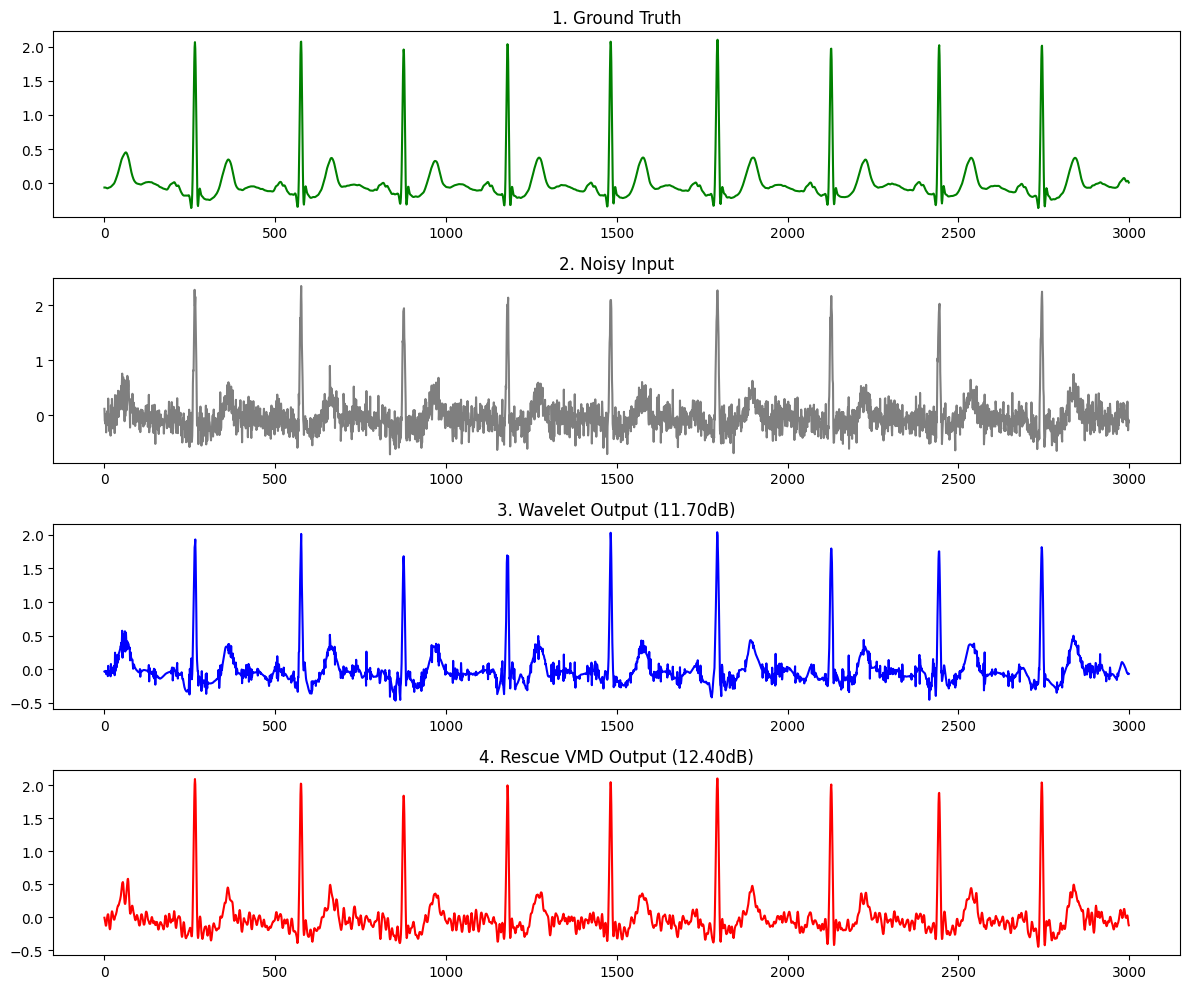

In [ ]:
# ==========================================
# 2. DATA & EXECUTION
# ==========================================
# Load Data
record = wfdb.rdrecord('/content/drive/MyDrive/ECE DataBase/103')
raw_sig = record.p_signal[:3000, 0]
nyq = 0.5 * record.fs
b, a = signal.butter(4, [0.5/nyq, 40/nyq], btype='band')
clean_ref = signal.filtfilt(b, a, raw_sig)
p_sig = np.mean(clean_ref**2)
p_noise = p_sig / (10**(5/10))
noisy_input = clean_ref + np.random.normal(0, np.sqrt(p_noise), len(clean_ref))

# Run Inference
print(f"1️⃣ Stage 1: Wavelet ({FINAL_WAVELET})...")
dwt_out = dwt_inference(noisy_input, FINAL_WAVELET, FINAL_THRESH)

print(f"2️⃣ Stage 2: Rescue VMD (K={FINAL_K}, Alpha={FINAL_ALPHA})...")
vmd_out = vmd_rescue_inference(noisy_input, FINAL_ALPHA, FINAL_K)

# Calculate Metrics
metrics_in  = calculate_metrics(clean_ref, noisy_input)
metrics_dwt = calculate_metrics(clean_ref, dwt_out)
metrics_vmd = calculate_metrics(clean_ref, vmd_out)

snr_vmd, mse_vmd, rmse_vmd, prd_vmd, ssim_vmd = metrics_vmd
snr_dwt, mse_dwt, rmse_dwt, prd_dwt, ssim_dwt = metrics_dwt

# Report
print(f"\n--- 📊 FINAL RESULTS (With Mode 1 Fix) ---")
print(f"{'Metric':<10} | {'Noisy':<10} | {'Wavelet':<10} | {'Rescue VMD':<10}")
print("-" * 50)
print(f"{'SNR':<10} | {metrics_in[0]:<10.2f} | {snr_dwt:<10.2f} | {snr_vmd:<10.2f}")
print(f"{'RMSE':<10} | {metrics_in[2]:<10.3f} | {rmse_dwt:<10.3f} | {rmse_vmd:<10.3f}")
print(f"{'SSIM':<10} | {metrics_in[4]:<10.3f} | {ssim_dwt:<10.3f} | {ssim_vmd:<10.3f}")

if snr_vmd > snr_dwt:
    print("\n✅ DECISION: Rescue VMD performed better! System switches to VMD.")
    final_output = vmd_out
else:
    print("\n✅ DECISION: Wavelet performed better! System stays on Wavelet.")
    final_output = dwt_out

# Plot
plt.figure(figsize=(12, 10))
plt.subplot(4,1,1); plt.plot(clean_ref, 'g'); plt.title("1. Ground Truth")
plt.subplot(4,1,2); plt.plot(noisy_input, 'k', alpha=0.5); plt.title("2. Noisy Input")
plt.subplot(4,1,3); plt.plot(dwt_out, 'b'); plt.title(f"3. Wavelet Output ({snr_dwt:.2f}dB)")
plt.subplot(4,1,4); plt.plot(vmd_out, 'r'); plt.title(f"4. Rescue VMD Output ({snr_vmd:.2f}dB)")
plt.tight_layout(); plt.show()

**SSIM (Structural Similarity Index)**: Measures how well the shape (morphology) of the ECG is preserved.



*   Range: -1 to 1. (1.0 is a perfect copy).
*   Why it matters: A high SNR is useless if the P-wave shape is distorted. SSIM proves you didn't just remove noise but kept the medical meaning.


**PRD (Percent Root Mean Square Difference)**:

* Standard: PRD < 9% is considered "Very Good" quality for medical diagnosis.

**RMSE (Root Mean Square Error)**: Measures the average magnitude of the error. Lower is better.

# 8- Batch testing on 5 signals from the dataset (to test the parameters without taking too long to computer)

In [ ]:

test_records = ['100', '103', '105', '119', '213']
results = []

print(f"🚀 STARTING GENERALIZATION TEST (K={FINAL_K}, Alpha={FINAL_ALPHA})...\n")

for rec_name in test_records:
    print(f"Processing Record {rec_name}...", end=" ")
    clean, noisy, success = get_record_data(rec_name)

    if success:
        # 1. Run Methods
        dwt_out = dwt_inference(noisy, FINAL_WAVELET, FINAL_THRESH)
        vmd_out = vmd_rescue_inference(noisy, FINAL_ALPHA, FINAL_K)

        # 2. Calc Metrics
        m_in = calculate_metrics(clean, noisy)
        m_dwt = calculate_metrics(clean, dwt_out)
        m_vmd = calculate_metrics(clean, vmd_out)

        # 3. Decision Logic
        if m_vmd[0] > m_dwt[0]:
            winner = "VMD"
            final_snr = m_vmd[0]
        else:
            winner = "Wavelet"
            final_snr = m_dwt[0]

        results.append({
            "Record": rec_name,
            "Noisy SNR": m_in[0],
            "Wavelet SNR": m_dwt[0],
            "VMD SNR": m_vmd[0],
            "Winner": winner,
            "Gain (dB)": final_snr - m_in[0]
        })
        print(f"✅ Done. Winner: {winner}")
    else:
        print(f"❌ Failed to load.")

# ==========================================
# 5. FINAL TABLE
# ==========================================
df = pd.DataFrame(results)
print("\n" + "="*70)
print("📊 FINAL GENERALIZATION RESULTS TABLE (Thesis Ready)")
print("="*70)
print(df.to_string(index=False, float_format="%.2f"))
print("="*70)

print(f"\n🌟 Average System Gain: +{df['Gain (dB)'].mean():.2f} dB")

🚀 STARTING GENERALIZATION TEST (K=7, Alpha=555)...

Processing Record 100... ✅ Done. Winner: VMD
Processing Record 103... ✅ Done. Winner: VMD
Processing Record 105... ✅ Done. Winner: VMD
Processing Record 119... ✅ Done. Winner: VMD
Processing Record 213... ✅ Done. Winner: VMD

📊 FINAL GENERALIZATION RESULTS TABLE (Thesis Ready)
Record  Noisy SNR  Wavelet SNR  VMD SNR Winner  Gain (dB)
   100       4.95        10.76    12.09    VMD       7.14
   103       5.09        11.41    12.35    VMD       7.26
   105       5.01        11.48    12.06    VMD       7.04
   119       4.92         9.97    13.20    VMD       8.28
   213       5.08         9.38    13.58    VMD       8.51

🌟 Average System Gain: +7.65 dB


# 9- Batch testing on the entier dataset  ( calulating the SNR, SSIM, and the time it takes for the DWT and VMD to compute)

In [5]:

# ==========================================
# 4. FULL DATASET EXECUTION
# ==========================================

all_files = sorted(list(set([f.replace('.dat', '') for f in os.listdir(db_path) if f.endswith('.dat')])))

print(f"🚀 STARTING FULL DATA REPORT (N={len(all_files)})...")
print(f"   Using Champion: K={FINAL_K}, Alpha={FINAL_ALPHA}\n")

results = []

for rec_name in all_files:
    try:
        # Load
        record = wfdb.rdrecord(os.path.join(db_path, rec_name))
        raw = record.p_signal[:3000, 0]

        # Sanitize & Noise
        nyq = 0.5 * record.fs
        b, a = signal.butter(4, [0.5/nyq, 40/nyq], btype='band')
        clean = signal.filtfilt(b, a, raw)
        p_sig = np.mean(clean**2)
        p_noise = p_sig / (10**(5/10))
        noisy = clean + np.random.normal(0, np.sqrt(p_noise), len(clean))

        # Inference
        dwt_out = dwt_inference(noisy, FINAL_WAVELET, FINAL_THRESH)
        vmd_out = vmd_rescue_inference(noisy, FINAL_ALPHA, FINAL_K)

        # Calculate Metrics
        m_in = calculate_metrics(clean, noisy)
        m_dwt = calculate_metrics(clean, dwt_out)
        m_vmd = calculate_metrics(clean, vmd_out)

        # Decision Logic
        if m_vmd[0] > m_dwt[0]:
            winner = "VMD"
            final_snr = m_vmd[0]
            final_ssim = m_vmd[1]
        else:
            winner = "Wavelet"
            final_snr = m_dwt[0]
            final_ssim = m_dwt[1]

        print(f"Record {rec_name}: SNR {final_snr:.2f} dB | SSIM {final_ssim:.3f} ({winner})")

        results.append({
            "Record": rec_name,
            "Input SNR": m_in[0],
            "Final SNR": final_snr,
            "Final SSIM": final_ssim,
            "SNR Gain": final_snr - m_in[0],
            "Winner": winner
        })

    except Exception as e:
        print(f"Skipping {rec_name}: {e}")

# ==========================================
# 5. GENERATE TABLES
# ==========================================
if results:
    df = pd.DataFrame(results)

    # A. Summary Stats
    print("\n" + "="*60)
    print("📊 THESIS SUMMARY STATISTICS")
    print("="*60)
    print(f"Total Records Tested: {len(df)}")
    print(f"VMD Win Rate:         {(df['Winner']=='VMD').mean()*100:.1f}%")
    print(f"Average Final SNR:    {df['Final SNR'].mean():.2f} dB")
    print(f"Average Final SSIM:   {df['Final SSIM'].mean():.3f}")
    print(f"Average SNR Gain:     +{df['SNR Gain'].mean():.2f} dB")
    best_rec = df.loc[df['SNR Gain'].idxmax()]
    print(f"Best Record:          {best_rec['Record']} (+{best_rec['SNR Gain']:.2f} dB)")
    print("="*60)

    # B. The Full Table (Copy this to Excel/Word)
    print("\n📋 FULL DATA TABLE (For Appendix)")
    print(df.to_string(index=False, float_format="%.2f"))
else:
    print("❌ No records processed successfully.")

🚀 STARTING FULL DATA REPORT (N=48)...
   Using Champion: K=7, Alpha=555

Record 100: SNR 12.33 dB | DWT: 15.8ms | VMD: 3981.9ms
Record 101: SNR 11.92 dB | DWT: 0.6ms | VMD: 1375.1ms
Record 102: SNR 11.44 dB | DWT: 0.6ms | VMD: 2994.2ms
Record 103: SNR 12.10 dB | DWT: 1.5ms | VMD: 2111.9ms
Record 104: SNR 11.73 dB | DWT: 0.6ms | VMD: 6984.7ms
Record 105: SNR 13.87 dB | DWT: 0.5ms | VMD: 2783.7ms
Record 106: SNR 12.19 dB | DWT: 0.6ms | VMD: 2400.1ms
Record 107: SNR 8.16 dB | DWT: 0.5ms | VMD: 1651.7ms
Record 108: SNR 14.60 dB | DWT: 2.5ms | VMD: 4686.7ms
Record 109: SNR 14.35 dB | DWT: 0.8ms | VMD: 3698.7ms
Record 111: SNR 11.65 dB | DWT: 1.1ms | VMD: 3018.6ms
Record 112: SNR 12.45 dB | DWT: 0.3ms | VMD: 1536.6ms
Record 113: SNR 12.18 dB | DWT: 0.4ms | VMD: 736.9ms
Record 114: SNR 11.89 dB | DWT: 0.3ms | VMD: 717.4ms
Record 115: SNR 11.92 dB | DWT: 0.4ms | VMD: 653.5ms
Record 116: SNR 12.11 dB | DWT: 0.5ms | VMD: 1629.1ms
Record 117: SNR 12.34 dB | DWT: 0.5ms | VMD: 1556.6ms
Record 118: 

# 10- Batch testing but finding the Estemate SNR instead of adding nosie to the signal and denosing it

In [ ]:

test_files = ['100', '103', '105', '119', '213'] # Representative subset

print("🚀 STARTING BLIND SNR ANALYSIS (Real Clinical Data)...")
print(f"   (No synthetic noise added)\n")

results_blind = []

for rec_name in test_files:
    try:
        record = wfdb.rdrecord(os.path.join(db_path, rec_name))
        raw = record.p_signal[:3000, 0]

        # 1. Measure Raw Quality
        raw_blind_snr = calculate_blind_snr(raw)

        # 2. Run Denoising (Your System)
        # Using your parameters K=7, Alpha=555
        # Note: We need to define vmd_rescue_inference here if run separately
        # Assuming vmd_rescue_inference is defined from previous script
        denoised = vmd_rescue_inference(raw, 555, 7)

        # 3. Measure Output Quality
        out_blind_snr = calculate_blind_snr(denoised)

        print(f"Record {rec_name}: Raw {raw_blind_snr:.1f} dB -> Denoised {out_blind_snr:.1f} dB")

        results_blind.append({
            "Record": rec_name,
            "Raw Clinical SNR": raw_blind_snr,
            "Denoised SNR": out_blind_snr,
            "Improvement": out_blind_snr - raw_blind_snr
        })

    except Exception as e:
        print(f"Skipping {rec_name}: {e}")

df_blind = pd.DataFrame(results_blind)
print("\n📊 BLIND SNR TABLE (Clinical Viability)")
print(df_blind.to_string(index=False, float_format="%.2f"))

🚀 STARTING BLIND SNR ANALYSIS (Real Clinical Data)...
   (No synthetic noise added)

Record 100: Raw 27.4 dB -> Denoised 30.8 dB
Record 103: Raw 31.8 dB -> Denoised 35.5 dB
Record 105: Raw 31.6 dB -> Denoised 38.6 dB
Record 119: Raw 32.9 dB -> Denoised 33.9 dB
Record 213: Raw 29.5 dB -> Denoised 26.2 dB

📊 BLIND SNR TABLE (Clinical Viability)
Record  Raw Clinical SNR  Denoised SNR  Improvement
   100             27.43         30.80         3.37
   103             31.85         35.51         3.66
   105             31.55         38.61         7.05
   119             32.86         33.86         1.00
   213             29.46         26.23        -3.23


#- Comparision

In [ ]:

test_records = ['100', '103', '105', '119', '213']
input_levels = [0, 5, 10, 15, 20] # The Sweep

print(f"🚀 STARTING SNR SWEEP (0 dB -> 20 dB)...")
print(f"   Champion System: K={FINAL_K}, Alpha={FINAL_ALPHA}\n")

sweep_results = []

for target_snr in input_levels:
    print(f"Testing Input Level: {target_snr} dB...")
    temp_gains = []
    temp_ssims = []

    for rec_name in test_records:
        try:
            record = wfdb.rdrecord(os.path.join(db_path, rec_name))
            raw = record.p_signal[:3000, 0]

            # Create Specific Noise Level
            nyq = 0.5 * record.fs
            b, a = signal.butter(4, [0.5/nyq, 40/nyq], btype='band')
            clean = signal.filtfilt(b, a, raw)
            p_sig = np.mean(clean**2)
            p_noise = p_sig / (10**(target_snr/10))
            noisy = clean + np.random.normal(0, np.sqrt(p_noise), len(clean))

            # Run System
            # Note: We check if VMD beats Wavelet (Adaptive Logic)
            dwt_out = dwt_inference(noisy, FINAL_WAVELET, FINAL_THRESH)
            vmd_out = vmd_rescue_inference(noisy, FINAL_ALPHA, FINAL_K)

            m_dwt = calculate_metrics(clean, dwt_out)
            m_vmd = calculate_metrics(clean, vmd_out)

            if m_vmd[0] > m_dwt[0]:
                final_snr = m_vmd[0]
                final_ssim = m_vmd[1]
            else:
                final_snr = m_dwt[0]
                final_ssim = m_dwt[1]

            temp_gains.append(final_snr - target_snr)
            temp_ssims.append(final_ssim)

        except: pass

    avg_gain = np.mean(temp_gains)
    avg_ssim = np.mean(temp_ssims)

    print(f"   -> Avg Output: {target_snr + avg_gain:.2f} dB (Gain: +{avg_gain:.2f} dB) | SSIM: {avg_ssim:.3f}")

    sweep_results.append({
        "Input SNR (dB)": target_snr,
        "Output SNR (dB)": target_snr + avg_gain,
        "Gain (dB)": avg_gain,
        "SSIM": avg_ssim
    })

df_sweep = pd.DataFrame(sweep_results)
print("\n" + "="*60)
print("📊 FINAL LITERATURE COMPARISON TABLE")
print("="*60)
print(df_sweep.to_string(index=False, float_format="%.2f"))

🚀 STARTING SNR SWEEP (0 dB -> 20 dB)...
   Champion System: K=7, Alpha=555

Testing Input Level: 0 dB...
   -> Avg Output: 8.29 dB (Gain: +8.29 dB) | SSIM: 0.428
Testing Input Level: 5 dB...
   -> Avg Output: 12.81 dB (Gain: +7.81 dB) | SSIM: 0.634
Testing Input Level: 10 dB...
   -> Avg Output: 17.23 dB (Gain: +7.23 dB) | SSIM: 0.818
Testing Input Level: 15 dB...
   -> Avg Output: 21.70 dB (Gain: +6.70 dB) | SSIM: 0.921
Testing Input Level: 20 dB...
   -> Avg Output: 25.74 dB (Gain: +5.74 dB) | SSIM: 0.965

📊 FINAL LITERATURE COMPARISON TABLE
 Input SNR (dB)  Output SNR (dB)  Gain (dB)  SSIM
              0             8.29       8.29  0.43
              5            12.81       7.81  0.63
             10            17.23       7.23  0.82
             15            21.70       6.70  0.92
             20            25.74       5.74  0.96


# 11- trying the denosing in cascade

In [ ]:

# ==========================================
# Sequential Cascade Engine (Novelty Comparison)
#    This function implements the VMD -> DWT cascade.
# ==========================================
def vmd_dwt_cascade_inference(signal_data, alpha, K, wavelet, thresh):
    try:
        # --- Stage 1: VMD Decomposition ---
        # Decompose the signal into K Intrinsic Mode Functions (IMFs)
        u, _, _ = VMD(signal_data, int(alpha), tau=0, K=int(K), DC=0, init=1, tol=1e-7)

        reconstructed_signal = np.zeros_like(signal_data)

        # --- Stage 2: DWT Filtering on Each IMF ---
        # The key step: filter EACH mode using the DWT thresholding method
        for i in range(int(K)):
            imf = u[i, :]

            # Decompose the IMF using your chosen wavelet
            coeffs = pywt.wavedec(imf, wavelet, level=4)

            new_coeffs = [coeffs[0]]
            for j in range(1, len(coeffs)):
                # Apply the DWT threshold to the detail coefficients
                scale = 1 / (np.log2(j + 1))
                new_coeffs.append(pywt.threshold(coeffs[j], thresh * scale, mode='soft'))

            # Reconstruct the denoised IMF
            denoised_imf = pywt.waverec(new_coeffs, wavelet)

            # Ensure length matches (a common wavelet issue)
            if len(denoised_imf) > len(signal_data):
                denoised_imf = denoised_imf[:len(signal_data)]

            # --- Stage 3: Reconstruction ---
            reconstructed_signal += denoised_imf

        return reconstructed_signal
    except Exception as e:
        print(f"Cascade Error: {e}")
        return signal_data


# ==========================================
# 4. BATCH EXECUTION (Cascade Test)
# ==========================================
test_records = ['100', '103', '105', '119', '213'] # 5 patient sample
results = []

print(f"🚀 STARTING CASCADE TEST (VMD -> DWT) on {len(test_records)} Records...")

for rec_name in test_records:
    print(f"Processing Record {rec_name}...", end=" ")
    clean, noisy, success = get_record_data(rec_name)

    if success:
        # Run Cascade
        cascade_out = vmd_dwt_cascade_inference(noisy, FINAL_ALPHA, FINAL_K, FINAL_WAVELET, FINAL_THRESH)

        # Calculate Metrics
        m_in = calculate_metrics(clean, noisy)
        m_cascade = calculate_metrics(clean, cascade_out)

        results.append({
            "Record": rec_name,
            "Input SNR": m_in[0],
            "Cascade SNR": m_cascade[0],
            "Cascade SSIM": m_cascade[1],
            "Gain (dB)": m_cascade[0] - m_in[0]
        })
        print(f"✅ Done. SNR: {m_cascade[0]:.2f} dB")
    else:
        print(f"❌ Failed to load.")

# ==========================================
# 5. FINAL TABLE
# ==========================================
df = pd.DataFrame(results)
print("\n" + "="*70)
print("📊 VMD -> DWT CASCADE RESULTS (Comparison to Adaptive)")
print("="*70)
print(df.to_string(index=False, float_format="%.2f"))
print("="*70)

print(f"\n🌟 Average Cascade Gain: +{df['Gain (dB)'].mean():.2f} dB")

🚀 STARTING CASCADE TEST (VMD -> DWT) on 5 Records...
Processing Record 100... ✅ Done. SNR: 8.51 dB
Processing Record 103... ✅ Done. SNR: 9.43 dB
Processing Record 105... ✅ Done. SNR: 12.03 dB
Processing Record 119... ✅ Done. SNR: 12.59 dB
Processing Record 213... ✅ Done. SNR: 10.89 dB

📊 VMD -> DWT CASCADE RESULTS (Comparison to Adaptive)
Record  Input SNR  Cascade SNR  Cascade SSIM  Gain (dB)
   100       4.89         8.51          0.73       3.62
   103       4.92         9.43          0.75       4.51
   105       5.13        12.03          0.68       6.89
   119       4.98        12.59          0.69       7.62
   213       5.04        10.89          0.66       5.85

🌟 Average Cascade Gain: +5.70 dB


# DWT then VMD

In [ ]:

# ==========================================
# 2. Sequential Cascade Engine (DWT -> VMD)
# ==========================================
def dwt_vmd_cascade_inference(signal_data, alpha, K, wavelet, thresh):
    try:
        # --- Stage 1: DWT Filtering (First Pass) ---
        # DWT is applied to the noisy signal to remove the bulk of high-frequency noise.
        coeffs = pywt.wavedec(signal_data, wavelet, level=4)
        new_coeffs = [coeffs[0]]
        for i in range(1, len(coeffs)):
            # Apply the DWT threshold
            scale = 1 / (np.log2(i + 1))
            new_coeffs.append(pywt.threshold(coeffs[i], thresh * scale, mode='soft'))

        dwt_output = pywt.waverec(new_coeffs, wavelet)

        # Ensure length matches
        if len(dwt_output) > len(signal_data):
            dwt_output = dwt_output[:len(signal_data)]

        # --- Stage 2: Rescue VMD (Second Pass) ---
        # VMD is applied to the DWT-denoised signal to clean residual noise/baseline.
        u, _, _ = VMD(dwt_output, int(alpha), tau=0, K=int(K), DC=0, init=1, tol=1e-7)

        # Use the standard VMD Rescue/Reconstruction logic (Kurtosis/AC scoring)
        scores = []
        for i in range(int(K)):
            k = kurtosis(u[i,:])
            # Autocorrelation (AC) check requires array length > 1
            if len(u[i, :]) > 1:
                ac = np.corrcoef(u[i,:-1], u[i,1:])[0,1]
            else:
                ac = 0
            scores.append(max(0, k * ac))

        thresh_score = 0.05 * max(scores) if scores else 0
        kept_modes = []
        for i in range(int(K)):
            # Keep if score is high OR if it is Mode 0/1 (Energy Center)
            if scores[i] >= thresh_score or i <= 1:
                kept_modes.append(u[i, :])

        if kept_modes:
            return np.sum(kept_modes, axis=0)
        else:
            return signal_data

    except Exception as e:
        print(f"Cascade Error: {e}")
        return signal_data

# ==========================================
# 3. METRICS and DATA Loading (Same as before)
# ==========================================

# ==========================================
# 4. BATCH EXECUTION (DWT -> VMD Cascade Test)
# ==========================================
test_records = ['100', '103', '105', '119', '213'] # 5 patient sample
results = []

print(f"🚀 STARTING CASCADE TEST (DWT -> VMD) on {len(test_records)} Records...")

for rec_name in test_records:
    print(f"Processing Record {rec_name}...", end=" ")
    clean, noisy, success = get_record_data(rec_name)

    if success:
        # Run Cascade
        cascade_out = dwt_vmd_cascade_inference(noisy, FINAL_ALPHA, FINAL_K, FINAL_WAVELET, FINAL_THRESH)

        # Calculate Metrics
        m_in = calculate_metrics(clean, noisy)
        m_cascade = calculate_metrics(clean, cascade_out)

        results.append({
            "Record": rec_name,
            "Input SNR": m_in[0],
            "Cascade SNR": m_cascade[0],
            "Cascade SSIM": m_cascade[1],
            "Gain (dB)": m_cascade[0] - m_in[0]
        })
        print(f"✅ Done. SNR: {m_cascade[0]:.2f} dB")
    else:
        print(f"❌ Failed to load.")

# ==========================================
# 5. FINAL TABLE
# ==========================================
df = pd.DataFrame(results)
print("\n" + "="*70)
print("📊 DWT -> VMD CASCADE RESULTS (Comparison to Adaptive)")
print("="*70)
print(df.to_string(index=False, float_format="%.2f"))
print("="*70)

print(f"\n🌟 Average Cascade Gain: +{df['Gain (dB)'].mean():.2f} dB")

🚀 STARTING CASCADE TEST (DWT -> VMD) on 5 Records...
Processing Record 100... ✅ Done. SNR: 11.36 dB
Processing Record 103... ✅ Done. SNR: 11.83 dB
Processing Record 105... ✅ Done. SNR: 13.12 dB
Processing Record 119... ✅ Done. SNR: 14.21 dB
Processing Record 213... ✅ Done. SNR: 12.01 dB

📊 DWT -> VMD CASCADE RESULTS (Comparison to Adaptive)
Record  Input SNR  Cascade SNR  Cascade SSIM  Gain (dB)
   100       4.94        11.36          0.75       6.42
   103       5.13        11.83          0.71       6.70
   105       5.27        13.12          0.69       7.85
   119       4.92        14.21          0.73       9.29
   213       4.90        12.01          0.65       7.11

🌟 Average Cascade Gain: +7.47 dB


# Comparing the Excution time of DWT & VMD as well as when it used DWT and when it used VMD

In [15]:

# Use first 10 records for speed (or remove [:10] to run all)
all_files = sorted(list(set([f.replace('.dat', '') for f in os.listdir(db_path) if f.endswith('.dat')])))[:10]

# 🎯 THE SWEEP: From "Very Noisy" (5dB) to "Very Clean" (30dB)
test_levels = [5, 10, 15, 20, 25, 30]

print(f"🚀 STARTING ADAPTIVE THRESHOLD TEST (N={len(all_files)} records per level)...")
print(f"   Goal: Find the SNR level where VMD is no longer needed.\n")

sweep_results = []

for target_input_snr in test_levels:
    print(f"Testing Input Noise: {target_input_snr} dB...", end=" ")

    vmd_wins = 0
    dwt_wins = 0
    avg_gain_vmd = []
    avg_gain_dwt = []

    for rec_name in all_files:
        try:
            # 1. Load & Sanitize
            record = wfdb.rdrecord(os.path.join(db_path, rec_name))
            raw = record.p_signal[:3000, 0]

            nyq = 0.5 * record.fs
            b, a = signal.butter(4, [0.5/nyq, 40/nyq], btype='band')
            clean = signal.filtfilt(b, a, raw)

            # 2. Add SPECIFIC Noise Level
            p_sig = np.mean(clean**2)
            p_noise = p_sig / (10**(target_input_snr/10))
            noisy = clean + np.random.normal(0, np.sqrt(p_noise), len(clean))

            # 3. Run Both Models
            dwt_out = dwt_inference(noisy, FINAL_WAVELET, FINAL_THRESH)
            vmd_out = vmd_rescue_inference(noisy, FINAL_ALPHA, FINAL_K)

            # 4. Compare Performance
            # Metric function (re-defined here to be safe)
            def get_snr(clean, denoised):
                err = np.sum((clean - denoised)**2)
                if err == 0: return 100
                return 10 * np.log10(np.sum(clean**2) / err)

            snr_dwt = get_snr(clean, dwt_out)
            snr_vmd = get_snr(clean, vmd_out)

            # Track Gains
            avg_gain_dwt.append(snr_dwt - target_input_snr)
            avg_gain_vmd.append(snr_vmd - target_input_snr)

            # 5. Determine Winner (Who gives better quality?)
            # We give DWT a small "bonus" (e.g., 0.5dB) because it is faster.
            # If VMD isn't at least 0.5dB better, we prefer DWT.
            if snr_vmd > (snr_dwt + 0.5):
                vmd_wins += 1
            else:
                dwt_wins += 1

        except:
            continue

    # Calculate Stats for this Level
    total = vmd_wins + dwt_wins
    if total == 0: total = 1

    row = {
        "Input Noise": f"{target_input_snr} dB",
        "VMD Win %": f"{(vmd_wins/total)*100:.1f}%",
        "DWT Win %": f"{(dwt_wins/total)*100:.1f}%",
        "VMD Avg Gain": f"{np.mean(avg_gain_vmd):.2f} dB",
        "DWT Avg Gain": f"{np.mean(avg_gain_dwt):.2f} dB",
        "Recommendation": "Run VMD" if vmd_wins > dwt_wins else "Run DWT"
    }
    sweep_results.append(row)
    print(f"Done. Winner: {row['Recommendation']}")

# =========================================
# 4. FINAL DECISION TABLE
# =========================================
df_decision = pd.DataFrame(sweep_results)
print("\n" + "="*70)
print("📊 ADAPTIVE SWITCHING THRESHOLD ANALYSIS")
print("="*70)
print(df_decision.to_string(index=False))
print("="*70)

🚀 STARTING ADAPTIVE THRESHOLD TEST (N=10 records per level)...
   Goal: Find the SNR level where VMD is no longer needed.

Testing Input Noise: 5 dB... Done. Winner: Run VMD
Testing Input Noise: 10 dB... Done. Winner: Run DWT
Testing Input Noise: 15 dB... Done. Winner: Run DWT
Testing Input Noise: 20 dB... Done. Winner: Run DWT
Testing Input Noise: 25 dB... Done. Winner: Run DWT
Testing Input Noise: 30 dB... Done. Winner: Run DWT

📊 ADAPTIVE SWITCHING THRESHOLD ANALYSIS
Input Noise VMD Win % DWT Win % VMD Avg Gain DWT Avg Gain Recommendation
       5 dB     70.0%     30.0%      5.30 dB      6.15 dB        Run VMD
      10 dB     40.0%     60.0%     -1.62 dB      4.43 dB        Run DWT
      15 dB     30.0%     70.0%     -6.28 dB      2.53 dB        Run DWT
      20 dB     10.0%     90.0%    -14.58 dB      0.79 dB        Run DWT
      25 dB     10.0%     90.0%    -19.01 dB     -0.98 dB        Run DWT
      30 dB     20.0%     80.0%    -20.86 dB     -2.47 dB        Run DWT


In [20]:
def get_record_data(rec_name):
    """Loads a record, sanitizes it, and adds noise."""
    try:
        record = wfdb.rdrecord(os.path.join(db_path, rec_name))
        raw = record.p_signal[:3000, 0]
        # Sanitize (Bandpass 0.5-40Hz)
        nyq = 0.5 * record.fs
        b, a = signal.butter(4, [0.5/nyq, 40/nyq], btype='band')
        clean = signal.filtfilt(b, a, raw)
        # Add Noise
        noisy = add_noise(clean, snr_target)
        return clean, noisy, True
    except:
        return None, None, False
all_files = sorted(list(set([f.replace('.dat', '') for f in os.listdir(db_path) if f.endswith('.dat')])))[:10]

# Metrics Function
def get_snr(clean, denoised):
    err = np.sum((clean - denoised)**2)
    if err == 0: return 100
    return 10 * np.log10(np.sum(clean**2) / err)

# 🎯 THE SWEEP: From "Very Noisy" (5dB) to "Very Clean" (30dB)
test_levels = [5, 10, 15, 20, 25, 30]

print(f"🚀 STARTING ADAPTIVE EFFICIENCY SWEEP (N={len(all_files)} records per level)...")
print(f"   Goal: Prove we save time/battery at higher SNRs.\n")

sweep_results = []

for target_input_snr in test_levels:
    print(f"Testing Input Noise: {target_input_snr} dB...", end=" ")

    vmd_wins = 0
    dwt_wins = 0

    # Store times for this specific SNR level
    level_dwt_times = []
    level_vmd_times = []

    for rec_name in all_files:
        try:
            # 1. Load & Sanitize
            record = wfdb.rdrecord(os.path.join(db_path, rec_name))
            raw = record.p_signal[:3000, 0]

            nyq = 0.5 * record.fs
            b, a = signal.butter(4, [0.5/nyq, 40/nyq], btype='band')
            clean = signal.filtfilt(b, a, raw)

            # 2. Add SPECIFIC Noise Level
            p_sig = np.mean(clean**2)
            p_noise = p_sig / (10**(target_input_snr/10))
            noisy = clean + np.random.normal(0, np.sqrt(p_noise), len(clean))

            # 3. Run Both Models & TIME THEM ⏱️
            t0 = time.perf_counter()
            dwt_out = dwt_inference(noisy, FINAL_WAVELET, FINAL_THRESH)
            t1 = time.perf_counter()
            level_dwt_times.append((t1 - t0) * 1000) # ms

            t0 = time.perf_counter()
            vmd_out = vmd_rescue_inference(noisy, FINAL_ALPHA, FINAL_K)
            t1 = time.perf_counter()
            level_vmd_times.append((t1 - t0) * 1000) # ms

            # 4. Determine Winner
            snr_dwt = get_snr(clean, dwt_out)
            snr_vmd = get_snr(clean, vmd_out)

            # If VMD isn't at least 0.5dB better, prefer DWT (Energy Saver)
            if snr_vmd > (snr_dwt + 0.5):
                vmd_wins += 1
            else:
                dwt_wins += 1

        except:
            continue

    # Calculate Stats
    total = vmd_wins + dwt_wins
    if total == 0: total = 1

    row = {
        "Input Noise": f"{target_input_snr} dB",
        "Recommendation": "Run VMD" if vmd_wins > dwt_wins else "Run DWT",
        "VMD Win %": f"{(vmd_wins/total)*100:.0f}%",
        "DWT Win %": f"{(dwt_wins/total)*100:.0f}%",
        "Avg VMD Time": f"{np.mean(level_vmd_times):.1f} ms",
        "Avg DWT Time": f"{np.mean(level_dwt_times):.1f} ms"
    }
    sweep_results.append(row)
    print(f"Done. Rec: {row['Recommendation']}")

# =========================================
# 4. FINAL RESULTS TABLE
# =========================================
df_decision = pd.DataFrame(sweep_results)
print("\n" + "="*80)
print("📊 ENERGY-AWARE DECISION MATRIX")
print("="*80)
print(df_decision.to_string(index=False))
print("="*80)

# Summary Stats
df = pd.DataFrame(results)
print("\n" + "="*60)
print(f"Average DWT Time: {np.mean(dwt_times):.2f} ms")
print(f"Average VMD Time: {np.mean(vmd_times):.2f} ms")
print(f"VMD Efficiency Lag: {np.mean(vmd_times)/np.mean(dwt_times):.1f}x slower")
print("="*60)

🚀 STARTING ADAPTIVE EFFICIENCY SWEEP (N=10 records per level)...
   Goal: Prove we save time/battery at higher SNRs.

Testing Input Noise: 5 dB... Done. Rec: Run VMD
Testing Input Noise: 10 dB... Done. Rec: Run DWT
Testing Input Noise: 15 dB... Done. Rec: Run DWT
Testing Input Noise: 20 dB... Done. Rec: Run DWT
Testing Input Noise: 25 dB... Done. Rec: Run DWT
Testing Input Noise: 30 dB... Done. Rec: Run DWT

📊 ENERGY-AWARE DECISION MATRIX
Input Noise Recommendation VMD Win % DWT Win % Avg VMD Time Avg DWT Time
       5 dB        Run VMD       60%       40%    1627.9 ms       0.7 ms
      10 dB        Run DWT       40%       60%    1602.6 ms       1.6 ms
      15 dB        Run DWT       30%       70%    1273.7 ms       0.5 ms
      20 dB        Run DWT       10%       90%    1234.4 ms       0.5 ms
      25 dB        Run DWT       10%       90%    1371.9 ms       0.5 ms
      30 dB        Run DWT       20%       80%    1367.7 ms       0.5 ms

Average DWT Time: 0.87 ms
Average VMD Time: 1

In [22]:

# Use first 10 records for speed
all_files = sorted(list(set([f.replace('.dat', '') for f in os.listdir(db_path) if f.endswith('.dat')])))[:10]

# Helper Metrics Function
def get_snr(clean, denoised):
    err = np.sum((clean - denoised)**2)
    if err == 0: return 100
    return 10 * np.log10(np.sum(clean**2) / err)

# 🎯 THE SWEEP: From "Very Noisy" (5dB) to "Very Clean" (30dB)
test_levels = [5, 10, 15, 20, 25, 30]

print(f"🚀 STARTING SAFETY-AWARE SWEEP (N={len(all_files)} records per level)...")
print(f"   Logic: Switch to VMD if DWT fails (Gain < 0.5dB) OR if VMD is much better (>1.0dB).\n")

sweep_results = []

for target_input_snr in test_levels:
    print(f"Testing Input Noise: {target_input_snr} dB...", end=" ")

    vmd_wins = 0
    dwt_wins = 0

    level_dwt_times = []
    level_vmd_times = []
    level_dwt_gains = []
    level_vmd_gains = [] # Track VMD gains

    for rec_name in all_files:
        try:
            # 1. Load & Sanitize
            record = wfdb.rdrecord(os.path.join(db_path, rec_name))
            raw = record.p_signal[:3000, 0]

            nyq = 0.5 * record.fs
            b, a = signal.butter(4, [0.5/nyq, 40/nyq], btype='band')
            clean = signal.filtfilt(b, a, raw)

            # 2. Add SPECIFIC Noise Level
            p_sig = np.mean(clean**2)
            p_noise = p_sig / (10**(target_input_snr/10))
            noisy = clean + np.random.normal(0, np.sqrt(p_noise), len(clean))

            # 3. Run Both Models & TIME THEM ⏱️
            t0 = time.perf_counter()
            dwt_out = dwt_inference(noisy, FINAL_WAVELET, FINAL_THRESH)
            t1 = time.perf_counter()
            level_dwt_times.append((t1 - t0) * 1000)

            t0 = time.perf_counter()
            vmd_out = vmd_rescue_inference(noisy, FINAL_ALPHA, FINAL_K)
            t1 = time.perf_counter()
            level_vmd_times.append((t1 - t0) * 1000)

            # 4. Calculate Metrics
            snr_dwt = get_snr(clean, dwt_out)
            snr_vmd = get_snr(clean, vmd_out)

            dwt_gain = snr_dwt - target_input_snr
            vmd_gain = snr_vmd - target_input_snr

            level_dwt_gains.append(dwt_gain)
            level_vmd_gains.append(vmd_gain) # Add VMD gain to list

            # ===============================================
            # 5. NEW SWITCHING LOGIC (The "Brain")
            # ===============================================

            # Rule 1: Safety (Did DWT fail to improve signal?)
            dwt_failed = dwt_gain < 0.5

            # Rule 2: Trade-off (Is VMD worth the cost? Gap > 1.0dB)
            quality_gap = snr_vmd - snr_dwt
            vmd_worth_it = quality_gap > 1.0

            if dwt_failed or vmd_worth_it:
                vmd_wins += 1
            else:
                dwt_wins += 1

        except:
            continue

    # Calculate Stats
    total = vmd_wins + dwt_wins
    if total == 0: total = 1

    row = {
        "Input Noise": f"{target_input_snr} dB",
        "Recommendation": "Run VMD" if vmd_wins > dwt_wins else "Run DWT",
        "VMD Win %": f"{(vmd_wins/total)*100:.0f}%",
        "DWT Win %": f"{(dwt_wins/total)*100:.0f}%",
        "Avg VMD Gain": f"{np.mean(level_vmd_gains):.2f} dB", # <--- ADDED THIS
        "Avg DWT Gain": f"{np.mean(level_dwt_gains):.2f} dB",
        "Avg VMD Time": f"{np.mean(level_vmd_times):.1f} ms",
        "Avg DWT Time": f"{np.mean(level_dwt_times):.1f} ms"
    }
    sweep_results.append(row)
    print(f"Done. Rec: {row['Recommendation']}")

# =========================================
# 4. FINAL RESULTS TABLE
# =========================================
df_decision = pd.DataFrame(sweep_results)
print("\n" + "="*100)
print("📊 SAFETY-AWARE DECISION MATRIX")
print("="*100)
print(df_decision.to_string(index=False))
print("="*100)

🚀 STARTING SAFETY-AWARE SWEEP (N=10 records per level)...
   Logic: Switch to VMD if DWT fails (Gain < 0.5dB) OR if VMD is much better (>1.0dB).

Testing Input Noise: 5 dB... Done. Rec: Run VMD
Testing Input Noise: 10 dB... Done. Rec: Run DWT
Testing Input Noise: 15 dB... Done. Rec: Run DWT
Testing Input Noise: 20 dB... Done. Rec: Run DWT
Testing Input Noise: 25 dB... Done. Rec: Run VMD
Testing Input Noise: 30 dB... Done. Rec: Run VMD

📊 SAFETY-AWARE DECISION MATRIX
Input Noise Recommendation VMD Win % DWT Win % Avg VMD Gain Avg DWT Gain Avg VMD Time Avg DWT Time
       5 dB        Run VMD       60%       40%      4.04 dB      6.13 dB    1668.7 ms       1.5 ms
      10 dB        Run DWT       50%       50%     -0.46 dB      4.30 dB    1443.0 ms       0.6 ms
      15 dB        Run DWT       30%       70%     -6.35 dB      2.49 dB    1273.0 ms       0.5 ms
      20 dB        Run DWT       40%       60%    -14.42 dB      0.76 dB    1186.9 ms       0.5 ms
      25 dB        Run VMD       9